# TSS Contour Mapping for Mississippi and Atchafalaya Rivers

This notebook generates contour maps comparing the extent of high Total Suspended Solids (TSS), proxied by Rrs_645 reflectance, for the Mississippi and Atchafalaya rivers across three different time periods.

Steps:
1. Import libraries.
2. Define dataset configurations (paths, rivers, dates, bounding boxes).
3. Define processing parameters (variables, binning, interpolation, blur).
4. Process each dataset:
    a. Find data files.
    b. Load Rrs_645 data.
    c. Extract data using GPU.
    d. Clip data to bounding box.
    e. Bin Rrs_645 data.
    f. Apply selective interpolation.
    g. Apply Gaussian blur.
    h. Calculate contour threshold (75th percentile).
    i. Store processed data.
5. Define a plotting function.
6. Generate and display the contour map for the Mississippi River.
7. Generate and display the contour map for the Atchafalaya River.

In [13]:
# 1. Import Libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter
from collections import defaultdict

# Import custom pipeline modules
from l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator

In [14]:
# 2. Define Dataset Configurations
base_data_dir = r"E:\satdata"

# Define bounding boxes
bbox = {
    'Mississippi': {'lon_min': -91.5, 'lon_max': -87.5, 'lat_min': 28.0, 'lat_max': 30.0},
    'Atchafalaya': {'lon_min': -92.5, 'lon_max': -90.5, 'lat_min': 28.5, 'lat_max': 30.0} # Adjusted BBox west of Mississippi
}

# Define datasets
datasets_config = [
    {'river': 'Mississippi', 'date': '2021-06-21_2021-07-21', 'path_fragment': 'Mississippi_2021-06-21_2021-07-21'},
    {'river': 'Mississippi', 'date': '2022-03-18_2022-04-16', 'path_fragment': 'Mississippi_2022-03-18_2022-04-16'},
    {'river': 'Mississippi', 'date': '2022-06-19_2022-07-19', 'path_fragment': 'Mississippi_2022-06-19_2022-07-19'},
    {'river': 'Atchafalaya', 'date': '2021-06-21_2021-07-21', 'path_fragment': 'Atchafalaya_2021-06-21_2021-07-21'},
    {'river': 'Atchafalaya', 'date': '2022-03-18_2022-04-16', 'path_fragment': 'Atchafalaya_2022-03-18_2022-04-16'},
    {'river': 'Atchafalaya', 'date': '2022-06-19_2022-07-19', 'path_fragment': 'Atchafalaya_2022-06-19_2022-07-19'},
]

# Add full path and bounding box to each config
for config in datasets_config:
    config['data_dir'] = os.path.join(base_data_dir, config['path_fragment'])
    config['bbox'] = bbox[config['river']]

print(f"Defined {len(datasets_config)} dataset configurations.")

Defined 6 dataset configurations.


In [15]:
# 3. Define Processing Parameters
tss_var = 'Rrs_645'  # Using Rrs_645 as a proxy for TSS
required_vars = [tss_var]

# Binning parameters (adjust for desired resolution)
lat_bins, lon_bins = 150, 200 # Slightly lower resolution for potentially larger area/multiple plots

# Interpolation parameters
interp_threshold = 32

# Gaussian blur parameters
blur_sigma = 1

# Contour percentile
contour_percentile = 75

In [16]:
# 4. Process Each Dataset
processed_data = defaultdict(dict)

loader = L2DatasetLoader(variables=required_vars)
extractor = GPUDataExtractor(variables=required_vars)

for config in datasets_config:
    river = config['river']
    date = config['date']
    data_dir = config['data_dir']
    current_bbox = config['bbox']
    lon_min, lon_max = current_bbox['lon_min'], current_bbox['lon_max']
    lat_min, lat_max = current_bbox['lat_min'], current_bbox['lat_max']

    print(f"\nProcessing: {river} - {date}")

    # a. Find data files
    nc_files = glob.glob(os.path.join(data_dir, '**', '*.nc'), recursive=True)
    if not nc_files:
        print(f"  No files found in {data_dir}. Skipping.")
        continue
    print(f"  Found {len(nc_files)} files.")

    # b. Load data
    datasets = loader.load_multiple(nc_files)
    if not datasets:
        print(f"  Failed to load datasets. Skipping.")
        continue
    print(f"  Loaded {len(datasets)} datasets.")

    # c. Extract data using GPU
    all_lon, all_lat, all_vars_dict = extractor.extract(datasets)
    if not len(all_lon):
        print(f"  No data extracted. Skipping.")
        continue
    print(f"  Extracted {len(all_lon)} data points.")

    # d. Clip data to bounding box
    mask = ((all_lon >= lon_min) & (all_lon <= lon_max) & (all_lat >= lat_min) & (all_lat <= lat_max))
    clipped_lon = all_lon[mask]
    clipped_lat = all_lat[mask]
    clipped_var_data = all_vars_dict[tss_var][mask]
    if not len(clipped_lon):
        print(f"  No data within bounding box. Skipping.")
        continue
    print(f"  Clipped to {len(clipped_lon)} points within BBox.")

    # e. Bin Rrs_645 data
    binned_tss_proxy, lat_edges, lon_edges, _ = binned_statistic_2d(
        clipped_lat, clipped_lon, clipped_var_data, statistic='mean', bins=[lat_bins, lon_bins],
        range=[[lat_min, lat_max], [lon_min, lon_max]]
    )
    print(f"  Binned {tss_var} data.")

    # f. Apply selective interpolation
    tss_proxy_interp = SelectiveInterpolator.interpolate(binned_tss_proxy, lat_edges, lon_edges, interp_threshold)
    print(f"  Applied selective interpolation (threshold={interp_threshold}).")

    # g. Apply Gaussian blur
    # Create a mask of original NaNs *before* filling them for blurring
    original_nan_mask = np.isnan(tss_proxy_interp)
    tss_proxy_blurred = tss_proxy_interp.copy()
    tss_proxy_blurred[original_nan_mask] = 0 # Replace NaNs with 0 before blurring
    tss_proxy_blurred = gaussian_filter(tss_proxy_blurred, sigma=blur_sigma)
    print(f"  Applied Gaussian blur (sigma={blur_sigma}).")

    # h. Calculate contour threshold
    valid_blurred_data = tss_proxy_blurred[~original_nan_mask] # Use original mask
    if len(valid_blurred_data) > 0:
        threshold = np.percentile(valid_blurred_data, contour_percentile)
        print(f"  Calculated {contour_percentile}th percentile threshold: {threshold:.6f}")
    else:
        print(f"  No valid data after processing to calculate threshold. Skipping storage.")
        threshold = None
        continue # Skip storing if no valid data

    # i. Store processed data
    lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
    lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
    lon_center_grid, lat_center_grid = np.meshgrid(lon_centers, lat_centers)

    processed_data[river][date] = {
        'lon_grid': lon_center_grid,
        'lat_grid': lat_center_grid,
        'blurred_data': tss_proxy_blurred,
        'threshold': threshold,
        'num_files': len(datasets)
    }
    print(f"  Stored processed data for {river} - {date}.")

print("\nProcessing complete.")


Processing: Mississippi - 2021-06-21_2021-07-21
  Found 41 files.
  Loaded 41 datasets.
  Extracted 12032063 data points.
  Clipped to 137795 points within BBox.
  Binned Rrs_645 data.
  Applied selective interpolation (threshold=32).
  Applied Gaussian blur (sigma=1).
  Calculated 75th percentile threshold: 0.001122
  Stored processed data for Mississippi - 2021-06-21_2021-07-21.

Processing: Mississippi - 2022-03-18_2022-04-16
  Found 17 files.
  Loaded 17 datasets.
  Extracted 9711667 data points.
  Clipped to 283327 points within BBox.
  Binned Rrs_645 data.
  Applied selective interpolation (threshold=32).
  Applied Gaussian blur (sigma=1).
  Calculated 75th percentile threshold: 0.002735
  Stored processed data for Mississippi - 2022-03-18_2022-04-16.

Processing: Mississippi - 2022-06-19_2022-07-19
  Found 46 files.
  Loaded 46 datasets.
  Extracted 17940028 data points.
  Clipped to 351880 points within BBox.
  Binned Rrs_645 data.
  Applied selective interpolation (threshold=

In [17]:
# 5. Define Plotting Function

def plot_river_contours(river_name, data_dict, river_bbox, title_suffix):
    """Plots contours for a given river across different dates."""
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    lon_min, lon_max = river_bbox['lon_min'], river_bbox['lon_max']
    lat_min, lat_max = river_bbox['lat_min'], river_bbox['lat_max']
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Add geographic features
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='darkgray', zorder=2)
    ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue', zorder=2)

    # Define colors for contours
    colors = plt.cm.viridis(np.linspace(0, 1, len(data_dict)))
    date_labels = sorted(data_dict.keys())

    contour_handles = []
    total_files = 0

    for i, date in enumerate(date_labels):
        plot_data = data_dict[date]
        if plot_data['threshold'] is not None:
            contour = ax.contour(
                plot_data['lon_grid'], plot_data['lat_grid'], plot_data['blurred_data'],
                levels=[plot_data['threshold']],
                colors=[colors[i]], # Pass color as a list
                linewidths=1.5,
                transform=ccrs.PlateCarree(),
                zorder=4
            )
            # Create a handle for the legend
            handle, _ = contour.legend_elements()
            if handle: # Check if handle list is not empty
                 contour_handles.append(handle[0]) # Use the first element
            total_files += plot_data['num_files']
        else:
             print(f"Skipping contour for {river_name} - {date} due to missing threshold.")

    # Add Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Add Legend
    if contour_handles:
        ax.legend(contour_handles, date_labels, title="Date Ranges", loc='upper right')

    # Add Title
    plt.title(f"{river_name} River - High {tss_var} Contours ({contour_percentile}th Percentile)\n{title_suffix}")
    plt.tight_layout()
    plt.show()

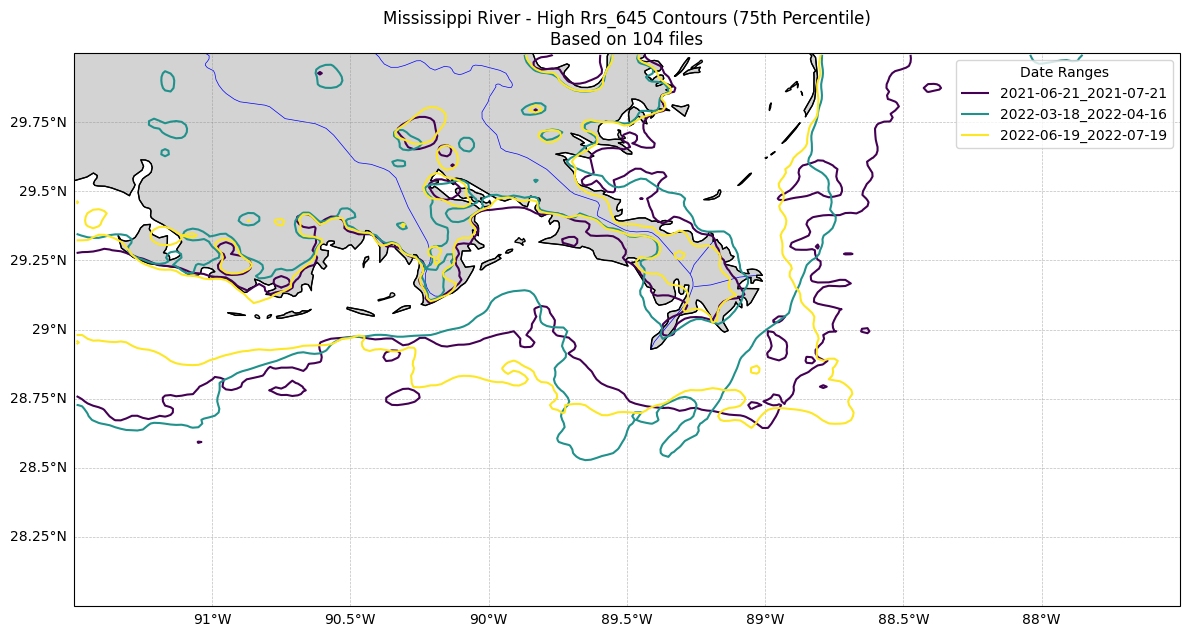

In [18]:
# 6. Generate and Display Mississippi Map
if 'Mississippi' in processed_data:
    plot_river_contours('Mississippi', processed_data['Mississippi'], bbox['Mississippi'], f"Based on {sum(d['num_files'] for d in processed_data['Mississippi'].values())} files")
else:
    print("No processed data available for Mississippi River.")

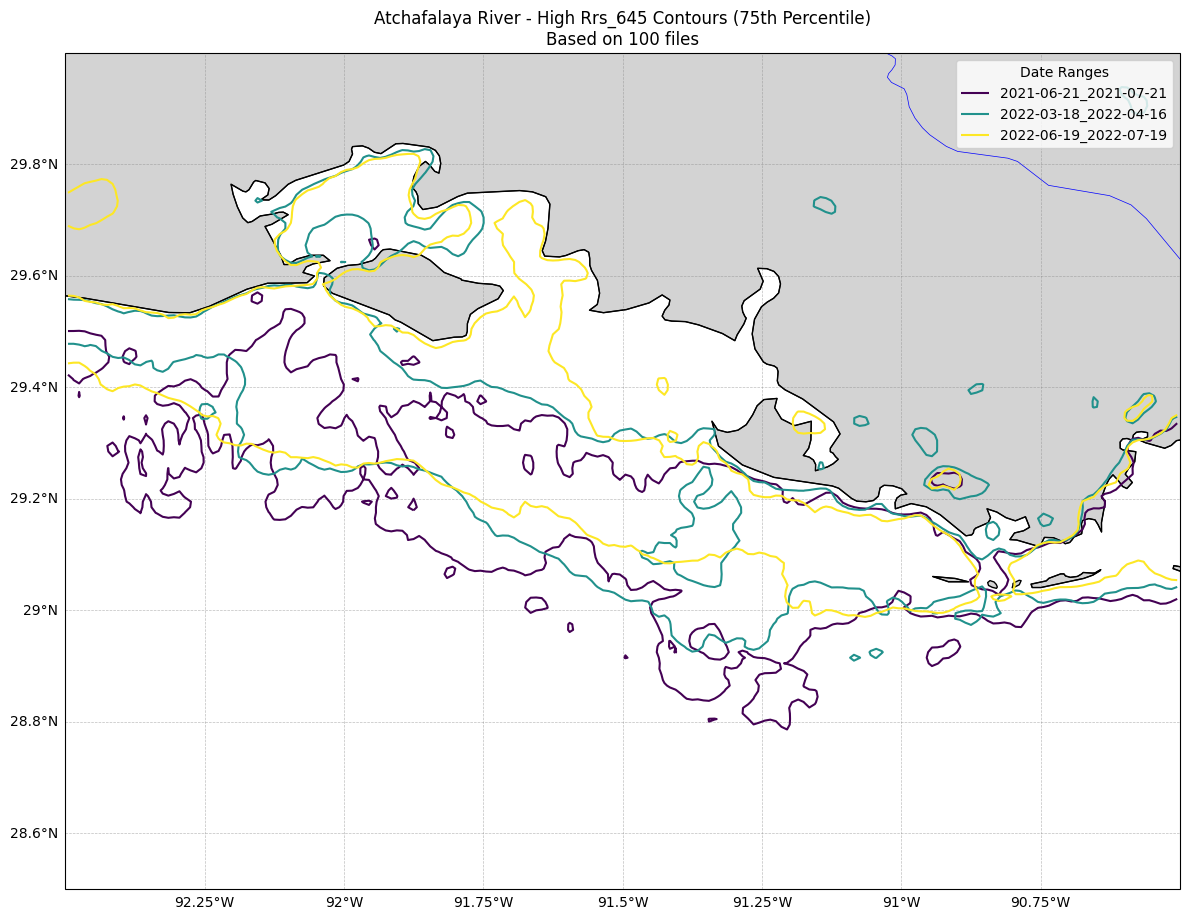

In [19]:
# 7. Generate and Display Atchafalaya Map
if 'Atchafalaya' in processed_data:
    plot_river_contours('Atchafalaya', processed_data['Atchafalaya'], bbox['Atchafalaya'], f"Based on {sum(d['num_files'] for d in processed_data['Atchafalaya'].values())} files")
else:
    print("No processed data available for Atchafalaya River.")